In [1]:
import os
import subprocess

# Math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import griddata

# GIS
import rasterio as rio
import rioxarray as rxr
import xarray as xr
import utm
from pyproj import Transformer
from xrspatial import hillshade
from rasterio.enums import Resampling

/Users/jarm/miniconda3/envs/lavaforming/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,"../py/")
import geotiff as gt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
gt.print_info_all()

Metadata for: ../dem/Reykjanes_Square.tif

Bounds: BoundingBox(left=325504.318, bottom=377726.35, right=329691.37, top=381238.176)
Width: 1396
Height: 1171
CRS: EPSG:3057
Transform: | 3.00, 0.00, 325504.32|
| 0.00,-3.00, 381238.18|
| 0.00, 0.00, 1.00|
Count: 4 (number of bands)
Dtype: uint8
Nodata value: None

Tags: {'AREA_OR_POINT': 'Area'}
Metadata for: ../dem/Reykjanes_Square_Raw.tif

Bounds: BoundingBox(left=325504.318, bottom=377726.35, right=329016.144, top=381238.176)
Width: 1171
Height: 1171
CRS: EPSG:3057
Transform: | 3.00, 0.00, 325504.32|
| 0.00,-3.00, 381238.18|
| 0.00, 0.00, 1.00|
Count: 1 (number of bands)
Dtype: float32
Nodata value: -3.4028234663852886e+38

Tags: {'AREA_OR_POINT': 'Area'}
Metadata for: ../dem/Reykjanes_Square_Geo.tif

Bounds: BoundingBox(left=0.0, bottom=1171.0, right=1396.0, top=0.0)
Width: 1396
Height: 1171
CRS: None
Transform: | 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
Count: 1 (number of bands)
Dtype: uint16
Nodata value: None

Tags

/Users/jarm/miniconda3/envs/lavaforming/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [130]:
gt.print_bands_info_all()

File: ../dem/Reykjanes_Square.tif
  Band 1:
    Nodata value: None
    Color interpretation: 3
    Min: 9.0
    Max: 75.0
  Band 2:
    Nodata value: None
    Color interpretation: 4
    Min: 9.0
    Max: 75.0
  Band 3:
    Nodata value: None
    Color interpretation: 5
    Min: 9.0
    Max: 75.0
  Band 4:
    Nodata value: None
    Color interpretation: 6
    Min: 255.0
    Max: 255.0
File: ../dem/Reykjanes_Square_Raw.tif
  Band 1:
    Nodata value: -3.4028234663852886e+38
    Color interpretation: 1
    Min: 17.923215866089
    Max: 110.66539764404
File: ../dem/Reykjanes_Square_Geo.tif
  Band 1:
    Nodata value: None
    Color interpretation: 1
    Min: 0.0
    Max: 12730.0
File: ../dem/Reykjanes_Square_Geo_Lg.tif
  Band 1:
    Nodata value: None
    Color interpretation: 1
    Min: 0.0
    Max: 13952.0


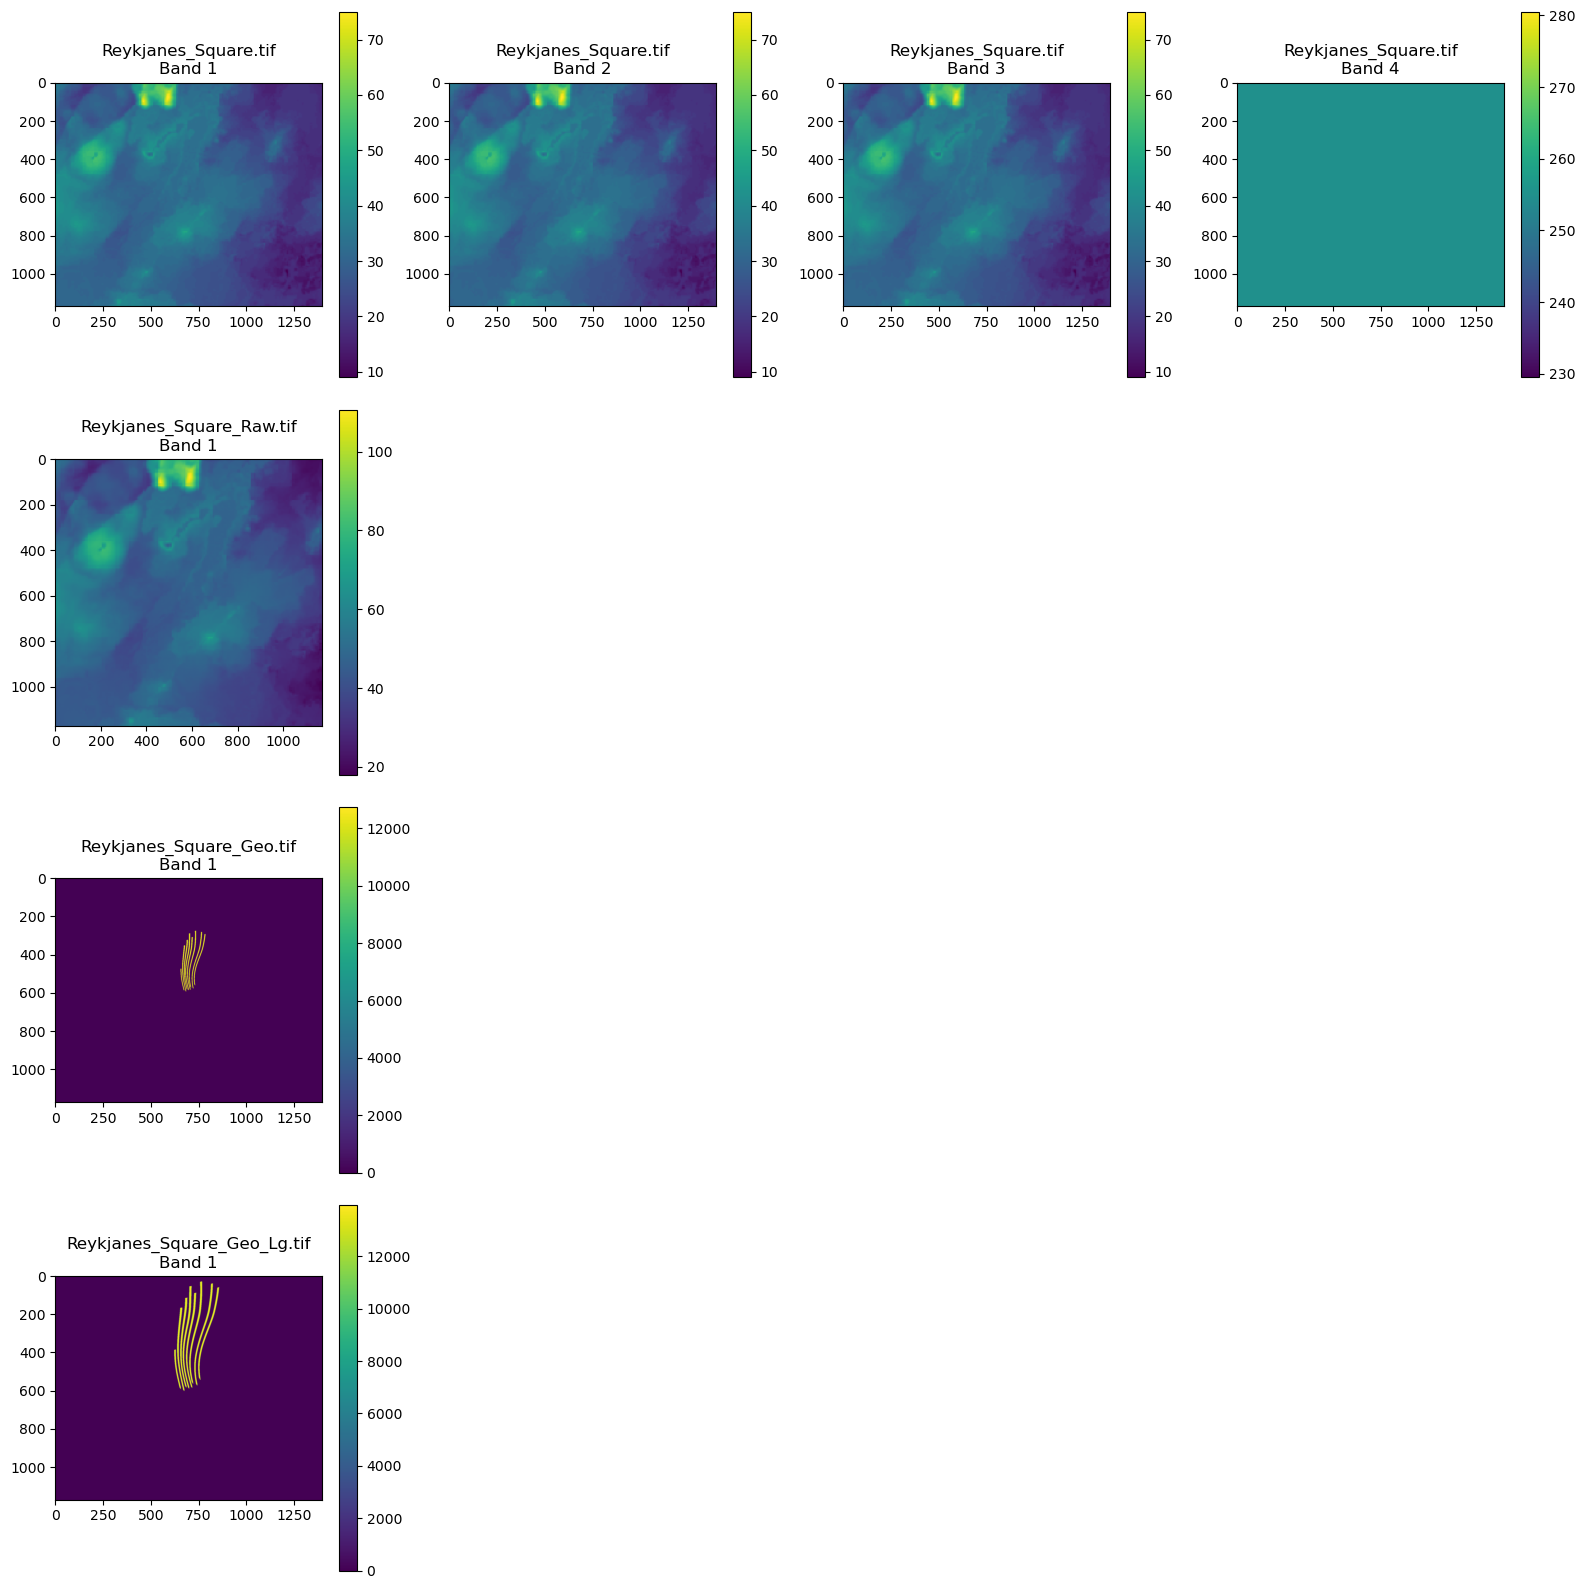

In [128]:
gt.plot_bands(gt.tif_paths)


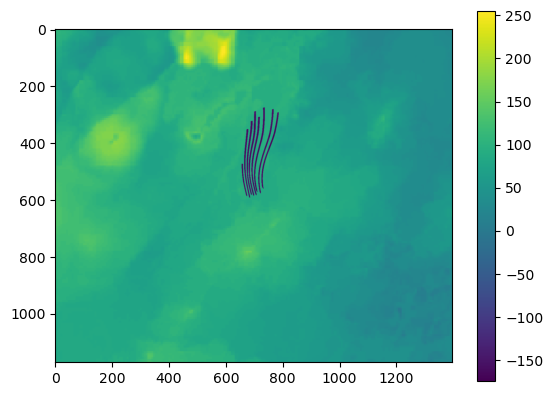

In [30]:
gt.plot_bands_diff(gt.tif_paths[0], 1, gt.tif_paths[2], 1, normalize=True)

    Shape: (1171, 1396)
    Dtype: uint8
    Min: 9
    Max: 75
    Shape: (1171, 1396)
    Dtype: uint16
    Min: 0
    Max: 12730


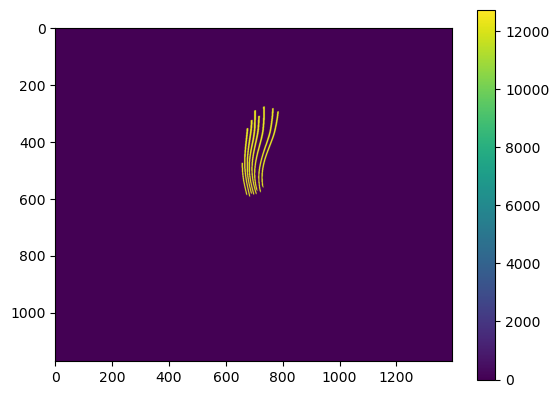

In [100]:
srcs = gt.read_tif_srcs()
len(srcs)
srcs[0]
gt.print_band_info(srcs[0].read(1))
gt.print_band_info(srcs[2].read(1))
gt.plot_band(srcs[2].read(1))


    Shape: (1171, 1396)
    Dtype: uint8
    Min: 9
    Max: 75
    Shape: (1171, 1396)
    Dtype: float64
    Min: 9.0
    Max: 50.0


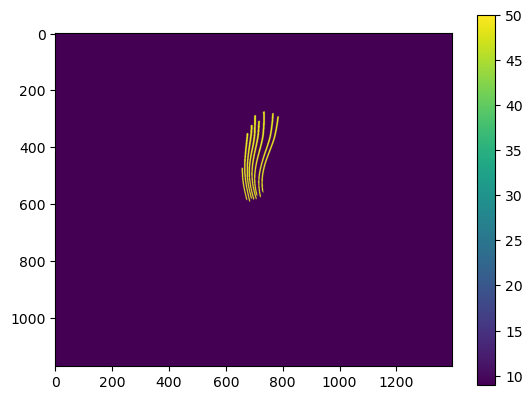

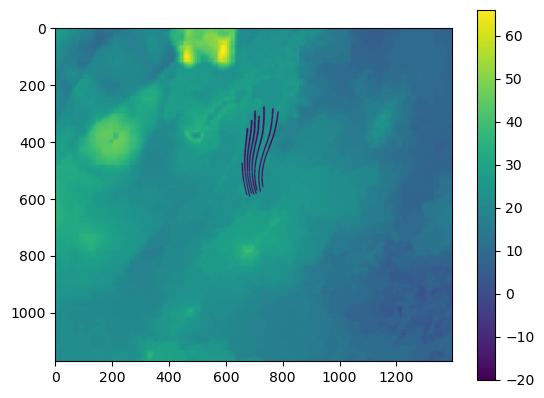

In [125]:
src2_min, src2_max = srcs[2].read(1).min(), srcs[2].read(1).max()
height_min, height_max = srcs[0].read(1).min(), srcs[0].read(1).max()
src2_rescaled = gt.rescale_band(srcs[2].read(1), src2_min, src2_max, height_min, 50)
gt.print_band_info(srcs[0].read(1))
gt.print_band_info(src2_rescaled)
gt.plot_band(src2_rescaled)
gt.plot_bands_diff(srcs[0].read(1), src2_rescaled)

    Shape: (1171, 1396)
    Dtype: float64
    Min: 9.0
    Max: 75.0


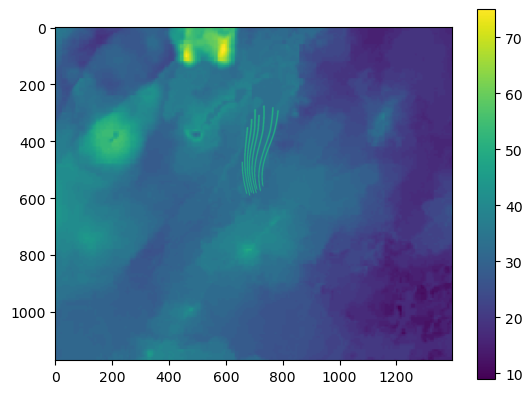

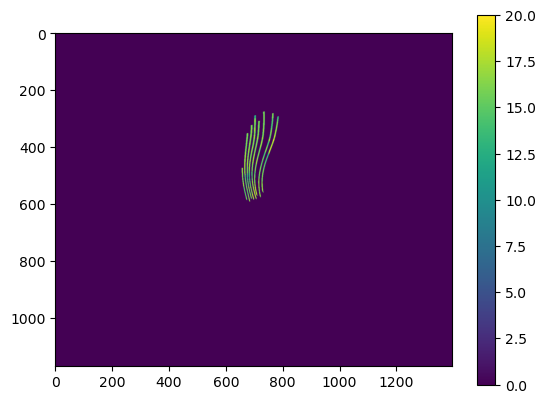

In [126]:
band_1 = gt.bands_blend_max(srcs[0].read(1), src2_rescaled)
gt.print_band_info(band_1)
gt.plot_band(band_1)
gt.plot_bands_diff(band_1, srcs[0].read(1))

In [148]:
gt.geotiff_from_band(band_1, srcs[0], "../dem/Reykjanes_Square_Geo_Out.tif")

In [149]:
src = srcs[0].read()
src.shape

(4, 1171, 1396)

In [151]:
out_file = "../dem/Reykjanes_Square_Geo_Out.tif"
srcs = gt.read_tif_srcs()
topo = srcs[0].read(1)
geom = srcs[2].read(1)

geom_min, geom_max = geom.min(), geom.max()
topo_height_min, topo_height_max = topo.min(), topo.max()
geom_rescaled = gt.rescale_band(geom, geom_min, geom_max, topo_height_min, 50)
band_1 = gt.bands_blend_max(topo, geom_rescaled)

out_meta = srcs[0].meta
out_meta.update(count=1)

gt.geotiff_from_band(band_1, out_meta, out_file)

In [156]:
hm_obj = gt.read_src("../dem/heightmap_objonly_comparison.tif")
hm_wall = gt.read_src("../dem/heightmap_wall.tif")
hm_walls = gt.read_src("../dem/heightmap_walls.tif")
hm_walls_tall = gt.read_src("../dem/heightmap_lavawalls_very_tall.tif")

/Users/jarm/miniconda3/envs/lavaforming/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [157]:
hm_wall_scaled = gt.rescale_band(hm_walls_tall.read(1), topo)
out_file = "../dem/heightmap_lavawalls_very_tall_out.tif"
gt.geotiff_from_band(hm_wall_scaled, out_meta, out_file)